# <font color='0000FF'> Multivariate Time Series Forecasting using XGBoost Regressor: A Machine Learning Approach</font>

#### The notebook aims to implement a **Machine learning based model** (**XGBoost Regressor**) on historical stock data of **INTEL**, spanning   **1980 to 2023**.

#### The primary objective is to forecast the **closing prices** of the stock capturing temporal patterns through relevant predictive variables.

#### XGBoost Regressor is a powerful machine learning algorithm based on the gradient boosting framework. It is an ensemble learning method that combines the predictions of multiple weak models (decision trees) to create a strong predictive model -> each tree is trained to correct the errors of the previous ones.

--- 

### XGBoost can be used for time series forecasting by  reframing the problem into a <span style="color:#0000FF;">supervised learning task </span> -> "transforming the time series data into a <span style="color:#0000FF;">supervised learning format"</span> This involves creating lagged features (past values) of the target variable and optionally for other relevant input variablesvto enable the model to learn patterns and predict future values.





# <span style="color:#0000FF;">Approach</span>

### <span style="color:#0000FF;">Data preparation:</span>

* Creating additional new features from <span style="color:#FFA500;">Date components</span> and <span style="color:#FFA500;">rolling statistics</span>
* Creating <span style="color:#FFA500;">lagged features</span> for all the relevant time series variables ,in our case, the <span style="color:#FFA500;">"Closing Price" and "High"</span> to serve as target and input variables respectively.

---

### <span style="color:#0000FF;">Defining the target variable</span>

* Defining the target variable as the <span style="color:#FFA500;">future value</span> we want to predict

---

### <span style="color:#0000FF;">Chronological Splitting</span>

* Preserve <span style="color:#FFA500;">temporal order</span> when splitting data into train/test sets


---
### <span style="color:#0000FF;">Defining Evaluation metrics and Creating a Baseline  model </span>

* We define a very basic **naive** model for later comparison with the trained model across the defined evaluation metrics

---
### <span style="color:#0000FF;">Model training</span>

* Train the <span style="color:#FFA500;">XGBoost regressor</span> on this structured dataset to learn <span style="color:#FFA500;">patterns and dependencies</span> across multiple time series

---

### <span style="color:#0000FF;">Making Predictions</span>

* Making <span style="color:#0000FF;">predictions one step ahead</span> in the future

---

### <span style="color:#0000FF;">Evaluate the model</span>

* Evaluate the model using appropriate performance metrics

---
### <span style="color:#0000FF;">Hyperparameter Tuning/Optimization</span>

* Using Grid Search  CV to find best parameters


### <span style="color:#0000FF;">Making Predictions (n steps ahead)</span>

* Making predictions for <span style="color:#FFA500;">n steps ahead</span> in the future

---




# <font color='FFA500'>Importing required libraries</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
import xgboost as xgb
import seaborn as sns



# <font color='FFA500'>Data Loading and Visualization</font>

In [2]:
df = pd.read_csv('I:/CQAI/TSA/TSD/TSD/archive (1)/INTEL (1980 - 11.07.2023).csv',usecols ={"Date","Close","High"})

df.head(),df.shape

(         Date      High     Close
 0  1980-03-18  0.328125  0.322917
 1  1980-03-19  0.335938  0.330729
 2  1980-03-20  0.334635  0.329427
 3  1980-03-21  0.322917  0.317708
 4  1980-03-24  0.316406  0.311198,
 (10919, 3))

In [3]:
df["Date"]=pd.to_datetime(df["Date"]) #convert date column to pandas datetime format

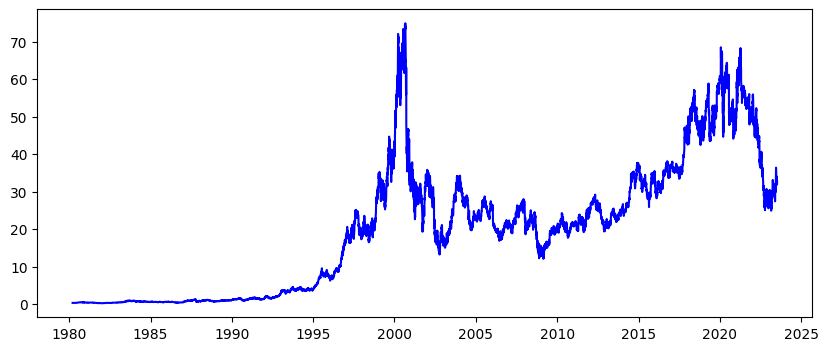

In [4]:

plt.figure(figsize=(10, 4))

plt.plot(df["Date"],df["Close"],label="Nividia Closing price", color="blue")




## <font color='FFA500'>Feature Engineering</font>

Features created:

* **Date features**: Extracting components like
dayofweek, year, day_of_year, sin_day, cos_day. These help the model understand seasonality and calendar effects.

* **Lag features**: Using past values of a variable as predictors (e.g., `Close_t-1`, `High_t-1`, etc.)
* **Rolling statistics**: Applying moving averagesto smooth and represent recent trends
* **Date Features**: Capturing seasonality and cyclic behavior in the time series data



In [5]:

# Creating Date features
df['dayofweek'] = df['Date'].dt.dayofweek
df['year'] = df['Date'].dt.year
df['dayofyear'] = df['Date'].dt.dayofyear
df['sin_day'] = np.sin(df['dayofyear'])
df['cos_day'] = np.cos(df['dayofyear'])
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year



In [6]:
#one step_behind from close
df["Close_t-1"] = df.Close.shift(1)
df["High_t-1"] = df.High.shift(1)

#Differnced feature
df["Close_diff"] = df.Close.diff(1)

#rolling feature
df["Rolling_mean"]=df.Close.rolling(20).mean().reset_index(level=0, drop=True)


## <font color='FFA500'>Transform to a Supervised Learning Problem </font >

Now we will create our target feature -> a  new column called **`next_day_close`** by shifting the **`Close`** values one step back.

This new column will contain the **one-step-ahead future values** of the `Close` price, making it suitable for supervised learning.



In [7]:
df['Close_next_day'] = df.Close.shift(-1)
df.head()

,Date,High,Close,dayofweek,year,dayofyear,sin_day,cos_day,month,Close_t-1,High_t-1,Close_diff,Rolling_mean,Close_next_day
0,1980-03-18,0.328125,0.322917,1,1980,78,0.513978,-0.857803,3,NaN,NaN,NaN,NaN,0.330729
1,1980-03-19,0.335938,0.330729,2,1980,79,-0.444113,-0.895971,3,0.322917,0.328125,0.007812,NaN,0.329427
2,1980-03-20,0.334635,0.329427,3,1980,80,-0.993889,-0.110387,3,0.330729,0.335938,-0.001302,NaN,0.317708
3,1980-03-21,0.322917,0.317708,4,1980,81,-0.629888,0.776686,3,0.329427,0.334635,-0.011719,NaN,0.311198
4,1980-03-24,0.316406,0.311198,0,1980,84,0.733190,-0.680023,3,0.317708,0.322917,-0.006510,NaN,0.312500


In [8]:
df = df.dropna(subset=['Close_next_day'])

In [9]:
df['Close_next_day'].tail()

10913    33.619999
10914    32.509998
10915    31.969999
10916    31.850000
10917    32.740002
Name: Close_next_day, dtype: float64


## <font color='FFA500'>Train/Test Split</font >

This step involves **chronological splitting** of the dataset.

We keep the **major portion** of the data for **training**, and use the **later sequential portion** for **testing**.

This preserves the **temporal order** and avoids data leakage, which is essential for time series forecasting tasks.



In [10]:
len(df)

10918

In [11]:
#we define a split value between train and test

split_idx = int(len(df) * 0.8)
print(split_idx)

8734


In [12]:
# Train data

df_train=df[:split_idx]
X_train=df_train.drop(['Close_next_day','Date'],axis=1).copy()

#Setting Close_next_day as the target feature
y_train=df_train['Close_next_day'].copy()


In [13]:
#Test data

df_test=df[split_idx:]
X_test=df_test.drop(['Close_next_day','Date'],axis=1).copy()
y_test=df_test['Close_next_day'].copy()

In [14]:
X_train.shape,X_test.shape,

((8734, 12), (2184, 12))

In [15]:
y_test.shape,y_train.shape

((2184,), (8734,))

# <font color='FFA500'>Evaluation metrics </font>


In [ ]:
from sklearn.metrics import mean_squared_error as MSE


def rmse(y_true, y_pred):
    rmse = np.sqrt(MSE(y_true, y_pred))
    print("Mean Value of Test Dataset:", y_test.mean())
    print("RMSE : % f" %(rmse))

def mape(y_true, y_pred):
    ape = np.abs((y_true - y_pred) / y_true)
    
    ape[~np.isfinite(ape)] = 1.
    print("Mape",np.mean(ape))

def wmape(y_true, y_pred):
    print("Wmape",np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)))

# <font color='FFA500'>Creating the Basline for Later evaluation</font>

The baseline model assumes that todays closing price will be the same as next days closing price. In this setup, the **predicted value** is set as today’s close, while the **true value** is the actual closing price of the following day. This provides a simple benchmark, representing the maximum error a naïve model might produce. Ideally, our trained model should achieve a lower error than this baseline.



In [17]:
y_pred = df_test["Close"]
y_true = df_test['Close_next_day']

In [18]:
mape(y_true,y_pred)
wmape(y_true,y_pred)

Mape 0.01403404955533739
Wmape 0.014251380880077104


## <font color='FFA500'>Handling Missing Values Before Training</font>

Before training, we re-inspect our dataset and impute the **NaN values** using the **`SimpleImputer`** with the default **mean strategy**.

These missing values were introduced as a result of the **new features** we added — such as **lagged features** and **rolling statistics** — which naturally create missing values at the beginning of the time series.

### Why this is important:
Imputing ensures that **each training example is complete**, allowing the model to learn effectively from all available data.



In [19]:
X_train.isnull().sum()


High             0
Close            0
dayofweek        0
year             0
dayofyear        0
sin_day          0
cos_day          0
month            0
Close_t-1        1
High_t-1         1
Close_diff       1
Rolling_mean    19
dtype: int64

In [20]:

from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
Xtr = imputer.fit_transform(X_train)


Xtst = imputer.transform(X_test)#This ensures that  preprocessing is consistent between training and testing.





## <font color='FFA500'>Model Training using `XGBRegressor` class from xgboost Library</font>


### Parameters used:

- Objective: regression with squared loss.
- n_estimators: The number of boosting (tree) rounds
- learning_rate: The step size shrinkage used to prevent overfitting

check out the documentation :https://xgboost.readthedocs.io/en/stable/parameter.html#


In [43]:
def fit_Regressor(x,y,n):
    reg = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n,
        learning_rate=0.01,
    )

    reg.fit(x, y,
            verbose=True,  #eval_set=[(X_train, y_train), (X_test, y_test)] , eval_metric='mae')
        ) 
    return reg





In [ ]:
reg =fit_Regressor(Xtr,y_train,230)

In [24]:
#Predict for test data
yhat = reg.predict(Xtst)

In [25]:
yhat

array([32.18184 , 32.428726, 32.500183, ..., 31.38361 , 30.459702,
       30.474905], dtype=float32)

In [26]:
y_test

8734     34.310001
8735     34.540001
8736     33.759998
8737     33.820000
8738     33.580002
           ...    
10913    33.619999
10914    32.509998
10915    31.969999
10916    31.850000
10917    32.740002
Name: Close_next_day, Length: 2184, dtype: float64

# <font color='FFA500'>Perform  Evaluation on Model predictions</font>

In [27]:
rmse(y_test, yhat)

mape(y_test, yhat)
wmape(y_test, yhat)

Mean Value of Test Dataset: 43.15017851923077
RMSE :  3.395802
Mape 0.06181969728770354
Wmape 0.06443764574924396


#### From the above results we see the mape and wmape for the trained model is high than the baseline which suggests model predictions are very poor 

# <font color='FFA500'>Plotting the Forecast (Original vs Predicted)</font>

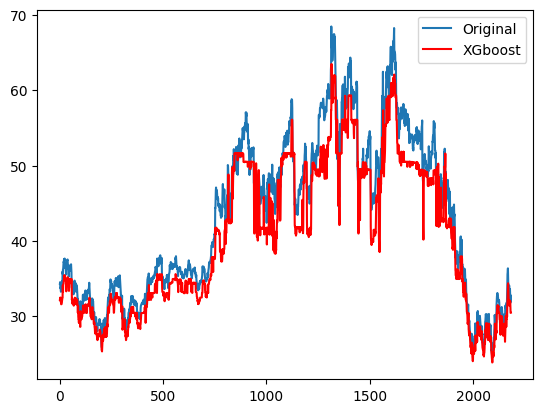

In [28]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

## <font color='FFA500'>Hyperparameter Tuning </font>

After training our initial model, we perform **hyperparameter tuning** to improve the model’s forecasting accuracy and generalization.

We use **`GridSearchCV`** from `sklearn.model_selection`, which automates the search for the best combination of hyperparameters.



`GridSearchCV` systematically tests multiple combinations of hyperparameters using **cross-validation**.

- Splits the training data into multiple folds (e.g., 5)
- Trains the model on a subset and validates it on the rest
- Repeats this process for each combination of parameters
- Returns the set of parameters that **produces the best average performance**


This ensures that the model does not overfit or underfit, and that the chosen parameters are optimal for generalizing to unseen data.




In [29]:

Xtr = pd.DataFrame(Xtr, columns=X_train.columns)
Xtst = pd.DataFrame(Xtst, columns=X_test.columns)


params = {
    'n_estimators': [600],# no of decision trees
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'max_depth': [2,3],
    'gamma': [0.3, 0.4],
    'min_child_weight': [4,5]
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
grid = GridSearchCV(xgb_reg, params)


In [30]:
grid.fit(Xtr, y_train)
gridcv_xgb = grid.best_estimator_


## <font color='FFA500'>About Hyperparameters</font>

### `min_child_weight`
Minimum sum of instance weight (Hessian) needed in a child node.  
➤ Larger values prevent the model from learning patterns that are too specific to individual samples (i.e., helps avoid overfitting).

---

### `gamma`
Minimum loss reduction required to make a further partition on a leaf node.  
➤ Acts as a regularization parameter — higher values make the algorithm more conservative by limiting tree growth.

---

### `subsample`
Fraction of the training data used to build each tree.  
➤ Adding this randomness reduces overfitting. Typical values are between **0.5 and 1.0**.

---

### `colsample_bytree`
Fraction of features (columns) randomly sampled for each tree.  
➤ Encourages diversity among trees and reduces overfitting by randomly ignoring some features at each iteration.

---

### `max_depth`
Maximum depth of a decision tree.  
➤ Controls the complexity of the model — deeper trees can model more intricate patterns but are prone to overfitting.


## <font color='FFA500'>Feature Importance Plot</font>

After training our best model using `GridSearchCV`, we visualize which features had the most impact on the model's predictions.



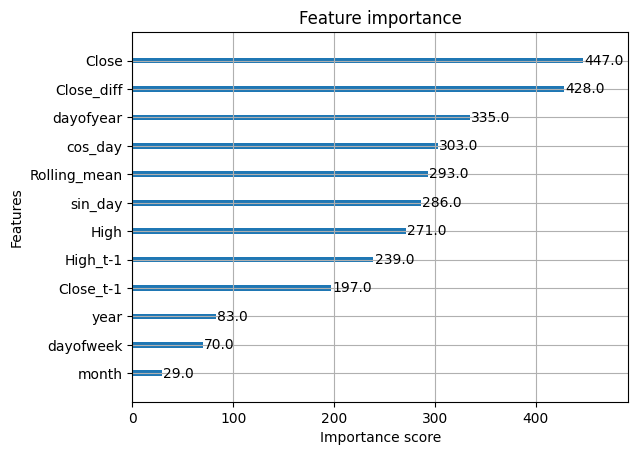

In [31]:

_ = plot_importance(gridcv_xgb)


In [32]:
gridcv_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.3, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, nthread=-1, ...)

In [33]:
yhat = grid.predict(Xtst)

In [34]:
rmse(y_test, yhat)

mape(y_test, yhat)
wmape(y_test, yhat)

Mean Value of Test Dataset: 43.15017851923077
RMSE :  2.094299
Mape 0.03131156751819206
Wmape 0.033588469781125375


#### From the above results we see that after tuning parameters the mape and wmape dropped form 0.06 to 0.03 which is progressively better and more closer to our baseline models metrics.

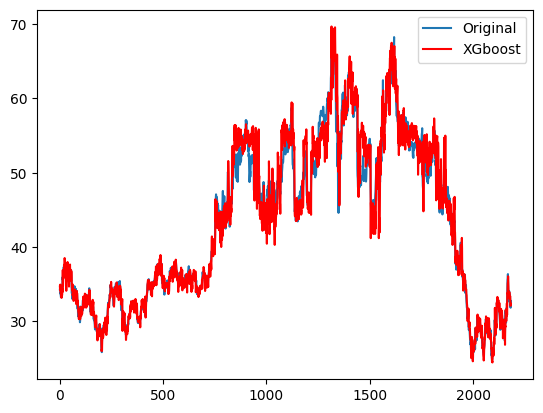

In [35]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

# <font color='FFA500'>Make Weekly Predictions (Target variable = next_week_close) </font>

In [36]:
weekly_data = df[df['dayofweek'] == 1].copy()
weekly_data

,Date,High,Close,dayofweek,year,dayofyear,sin_day,cos_day,month,Close_t-1,High_t-1,Close_diff,Rolling_mean,Close_next_day
0,1980-03-18,0.328125,0.322917,1,1980,78,0.513978,-0.857803,3,NaN,NaN,NaN,NaN,0.330729
5,1980-03-25,0.317708,0.312500,1,1980,85,-0.176076,-0.984377,3,0.311198,0.316406,0.001302,NaN,0.309896
10,1980-04-01,0.328125,0.322917,1,1980,92,-0.779466,-0.626444,4,0.321615,0.326823,0.001302,NaN,0.325521
14,1980-04-08,0.317708,0.312500,1,1980,99,-0.999207,0.039821,4,0.311198,0.316406,0.001302,NaN,0.305990
19,1980-04-15,0.308594,0.303385,1,1980,106,-0.727143,0.686487,4,0.307292,0.312500,-0.003907,0.314193,0.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10891,2023-05-30,30.040001,29.990000,1,2023,150,-0.714876,0.699251,5,29.000000,29.090000,0.990000,29.699000,31.440001
10896,2023-06-06,31.450001,30.959999,1,2023,157,-0.079549,0.996831,6,29.860001,31.400000,1.099998,29.763000,31.280001
10901,2023-06-13,33.950001,33.910000,1,2023,164,0.594933,0.803775,6,33.070000,33.299999,0.840000,30.450000,35.580002
10905,2023-06-20,37.110001,35.000000,1,2023,171,0.976591,0.215105,6,36.369999,36.799999,-1.369999,31.703500,32.900002


In [37]:
len(weekly_data)

2238

In [38]:
split_idx = int(len(weekly_data) * 0.9)
print(split_idx)

2014


In [39]:
weekly_data.rename(columns ={'Close_next_day':'Close_next_week'},inplace=True)

In [40]:
df_train=weekly_data[:split_idx]
X_train=df_train.drop(['Close_next_week','Date',],axis=1).copy()
y_train=df_train['Close_next_week'].copy()


In [41]:
df_test=weekly_data[split_idx:]
X_test=df_test.drop(['Close_next_week','Date',],axis=1).copy()
y_test=df_test['Close_next_week'].copy()

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
Xtr = imputer.fit_transform(X_train)


Xtst = imputer.transform(X_test) #This ensures that  preprocessing is consistent between training and testing.



In [ ]:
reg = fit_Regressor(Xtr,y_train,600)  #no of estimators = 600 "from grid search cv "

In [45]:
#Predict for test data
yhat = reg.predict(Xtst)

In [46]:
y_test.shape, yhat.shape


((224,), (224,))

In [47]:
rmse(y_test, yhat)
mape(y_test, yhat)
wmape(y_test, yhat)

Mean Value of Test Dataset: 47.93718738839285
RMSE :  1.593557
Mape 0.023720529593762415
Wmape 0.024556221123795293


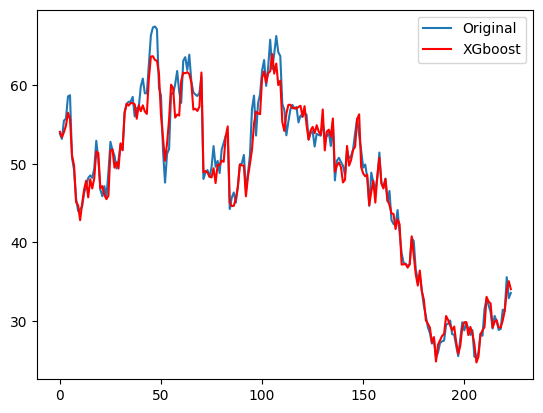

In [48]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()